Majority of the code taken from the TransFusion github implementation (https://github.com/fahim-sikder/TransFusion)

In [40]:
import random
import math
from functools import partial
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm import tqdm

random.seed(42)
np.random.seed(42)

# Params

In [41]:
seq_len = 15
epochs = 1
timesteps = 1000
batch_size = 32
latent_dim = 256
num_layers = 6
n_heads = 8    
beta_schedule = "linear"
objective = "pred_noise"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mode = 'diffusion'
architecture = 'custom-transformers'
loss_mode = 'l1'

# Data

In [42]:
def normalize(data):
    
    min_val = np.min(np.min(data, axis=0), axis=0)
    data = data - min_val

    max_val = np.max(np.max(data, axis=0), axis=0)
    data = data / (max_val + 1e-7)
    
    data = data.astype(np.float32)
    
    return data

class MakeDATA(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        
        data = np.asarray(data, dtype= np.float32)
        norm_data = normalize(data)

        seq_data = []
        for i in range(len(norm_data) - seq_len + 1):
            x = norm_data[i : i + seq_len]
            seq_data.append(x)

        self.samples = []
        idx = torch.randperm(len(seq_data))
        for i in range(len(seq_data)):
            self.samples.append(seq_data[idx[i]])
            
        self.samples = np.asarray(self.samples, dtype = np.float32)
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def data_preprocess():
    
    data_dir = f'./data/LCL-June2015v2_0.csv'
    
    data = pd.read_csv(data_dir)
    data = data.iloc[:1000, 3] #DEV only use small portion
        
    return data

def LoadData(seq_len):
    data = data_preprocess() 
    data = MakeDATA(data, seq_len)
    train_data, test_data = train_test_split(data, train_size = 0.8, random_state = 2021)
    return train_data, test_data

In [43]:
train_data, test_data = LoadData(seq_len=seq_len)
train_data, test_data = np.asarray(train_data), np.asarray(test_data)

if len(train_data.shape) < 3:
    train_data = np.expand_dims(train_data, axis=-1)
    test_data = np.expand_dims(test_data, axis=-1)

features = train_data.shape[2]
print(f"num of channels in transformer: {features}")

train_data, test_data = train_data.transpose(0,2,1), test_data.transpose(0,2,1)
print(f"Train shape (batch, features, seq_len): {train_data.shape}")


train_loader = torch.utils.data.DataLoader(train_data, batch_size)
test_loader = torch.utils.data.DataLoader(test_data, len(test_data))

real_data = next(iter(train_loader))
print(f"batched data shape: {real_data.shape}")

num of channels in transformer: 1
Train shape (batch, features, seq_len): (788, 1, 15)
batched data shape: torch.Size([32, 1, 15])


# Transformer Encoder
## Embeddings

In [44]:
class TimestepEmbedder(nn.Module):
    def __init__(self, latent_dim, sequence_pos_encoder):
        super().__init__()
        self.latent_dim = latent_dim
        self.sequence_pos_encoder = sequence_pos_encoder

        time_embed_dim = self.latent_dim
        self.time_embed = nn.Sequential(
            nn.Linear(self.latent_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

    def forward(self, timesteps):
        return self.time_embed(self.sequence_pos_encoder.pe[timesteps]).permute(1, 0, 2)
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # not used in the final model
        x = x + self.pe[:x.shape[0], :]
        return self.dropout(x)

## Encoder

In [45]:
class TransEncoder(nn.Module):
    
    def __init__(self, features, latent_dim, num_heads, num_layers = 6, dropout = 0.1, activation = 'gelu', ff_size = 1024):
        
        super().__init__()

        self.channels = features
        self.self_condition = None
        self.latent_dim  = latent_dim
        self.num_heads = num_heads
        self.ff_size = ff_size
        self.activation = activation
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.pos_enc = PositionalEncoding(self.latent_dim)
        self.emb_timestep = TimestepEmbedder(self.latent_dim, self.pos_enc)
        self.input_dim = nn.Linear(self.channels, self.latent_dim)
        print(f"num of channels in transformer: {self.channels}")
        self.output_dim = nn.Linear(self.latent_dim, self.channels)
        self.TransEncLayer = nn.TransformerEncoderLayer(d_model=self.latent_dim,
                                                  nhead=self.num_heads,
                                                  dim_feedforward=self.ff_size,
                                                  dropout=self.dropout,
                                                  activation=self.activation)

        self.TransEncodeR = nn.TransformerEncoder(self.TransEncLayer,
                                                     num_layers=self.num_layers)
        
        
    def forward(self, x, t, x_self_cond = None):
        #print(f"Input shape: {x.shape}")
        x = torch.transpose(x, 1, 2)
        #print(f"Transposed shape: {x.shape}")
        x = self.input_dim(x)
        #print(f"Input dim shape after linear: {x.shape}")
        x = torch.transpose(x, 0, 1)
        #print(f"Input dim shape after transpose: {x.shape}")
        embed = self.emb_timestep(t)
        #print(f"Time embedding shape: {embed.shape}")
        time_added_data = torch.cat((embed, x), axis = 0)
        #print(f"Time added data shape: {time_added_data.shape}")
        time_added_data = self.pos_enc(time_added_data)
        #print(f"Time added data shape after pos enc: {time_added_data.shape}")
        trans_output = self.TransEncodeR(time_added_data)[1:]
        #print(f"Transformer Encoded output shape: {trans_output.shape}")
        final_output = self.output_dim(trans_output)
        #print(f"Transformer Encoded after linear output shape: {final_output.shape}")
        transposed_data = final_output.permute(1, 2, 0)
        #print(f"Final output shape: {transposed_data.shape}")
        return transposed_data

## Transformer Diagnostics

In [46]:
batch = next(iter(train_loader))
b, c, n, seq_length, = *batch.shape, seq_len
t = torch.randint(0, 1000, (b,)).long()


diagnostic_model = TransEncoder(features = features,latent_dim = latent_dim,num_heads = n_heads,num_layers = num_layers)
predicted_noise = diagnostic_model(batch, t)

print(f"Shape of predicted noise: {predicted_noise.shape}")

num of channels in transformer: 1
Shape of predicted noise: torch.Size([32, 1, 15])


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# DDPM
## Helper functions

In [47]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

# normalization functions
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

## GaussianDiffusion1D

In [48]:
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

In [49]:
class GaussianDiffusion1D(nn.Module):
    def __init__(
        self,
        model,
        *,
        seq_length,
        timesteps = 1000,
        sampling_timesteps = None,
        loss_type = 'l1',
        beta_schedule = 'cosine',
        p2_loss_weight_gamma = 0.,
        p2_loss_weight_k = 1,
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels
        self.self_condition = self.model.self_condition
        self.seq_length = seq_length

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        # sampling related parameters
        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps

        # helper function to register buffer from float64 to float32
        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # calculate p2 reweighting
        register_buffer('p2_loss_weight', (p2_loss_weight_k + alphas_cumprod / (1 - alphas_cumprod)) ** -p2_loss_weight_gamma)

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, x_self_cond = None, clip_x_start = False):
        model_output = self.model(x, t, x_self_cond)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity
        
        pred_noise = model_output
        x_start = self.predict_start_from_noise(x, t, pred_noise)
        x_start = maybe_clip(x_start)


        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, x_self_cond = None, clip_denoised = True):
        preds = self.model_predictions(x, t, x_self_cond)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, x_self_cond = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((x.shape[0],), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, self_cond)

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16):
        seq_length, channels = self.seq_length, self.channels
        sample_fn = self.p_sample_loop 
        return sample_fn((batch_size, channels, seq_length))

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    @property
    def loss_fn(self):
        if self.loss_type == 'l1':
            return F.l1_loss
        elif self.loss_type == 'l2':
            return F.mse_loss
        else:
            raise ValueError(f'invalid loss type {self.loss_type}')

    def p_losses(self, x_start, t, noise = None):
        b, c, n = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond)
        target = noise
  

        loss = self.loss_fn(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b (...)', 'mean')

        loss = loss * extract(self.p2_loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, n, device, seq_length, = *img.shape, img.device, self.seq_length
        assert n == seq_length, f'seq length must be {seq_length}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = normalize_to_neg_one_to_one(img)
        
        # print(f'shape after normalizing: {img.shape}')
        return self.p_losses(img, t, *args, **kwargs)

# Train

In [50]:
model = TransEncoder(
        features = features,
        latent_dim = latent_dim,
        num_heads = n_heads,
        num_layers = num_layers
    )

diffusion = GaussianDiffusion1D(
        model,
        seq_length = seq_len,
        timesteps = timesteps,  
        loss_type = 'l2',
        beta_schedule = beta_schedule
    )
    
diffusion = diffusion.to(device)

lr = 1e-4
betas = (0.9, 0.99)
optim = torch.optim.Adam(diffusion.parameters(), lr = lr, betas = betas)

num of channels in transformer: 1


In [51]:
for running_epoch in tqdm(range(epochs)):
    for i, data in enumerate(train_loader):
        data = data.to(device)
        batch_size = data.shape[0]
        optim.zero_grad()
        loss = diffusion(data)
        loss.backward()
        optim.step()
    
    if i%len(train_loader)== 0 and running_epoch%10==0:
        print(f'Epoch: {running_epoch+1}, Loss: {loss.item()}')

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


# Sampling

In [52]:
with torch.no_grad():
    samples = diffusion.sample(len(test_data))
    samples = samples.cpu().numpy()
    samples = samples.transpose(0, 2, 1)

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 186.91it/s]

Samples shape: (198, 15, 1)


# Evaluation

In [54]:
def visualize(ori_data, fake_data, seq_len):
    ori_data = np.asarray(ori_data)
    fake_data = np.asarray(fake_data)
    
    ori_data = ori_data[:fake_data.shape[0]]
    
    sample_size = 250
    idx = np.random.permutation(len(ori_data))[:sample_size]
    randn_num = np.random.permutation(sample_size)[:1]
    
    real_sample = ori_data[idx]
    fake_sample = fake_data[idx]
    
    real_sample_2d = real_sample.reshape(-1, seq_len)
    fake_sample_2d = fake_sample.reshape(-1, seq_len)
    
    ### PCA ###
    pca = PCA(n_components=2)
    pca.fit(real_sample_2d)
    pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
                .assign(Data='Real'))
    pca_synthetic = (pd.DataFrame(pca.transform(fake_sample_2d))
                     .assign(Data='Synthetic'))
    pca_result = pd.concat([pca_real, pca_synthetic]).rename(
        columns={0: '1st Component', 1: '2nd Component'})
    
    ### TSNE ###
    tsne_data = np.concatenate((real_sample_2d, fake_sample_2d), axis=0)
    
    tsne = TSNE(n_components=2, verbose=0, perplexity=40)
    tsne_result = tsne.fit_transform(tsne_data)
    tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
    tsne_result.loc[len(real_sample_2d):, 'Data'] = 'Synthetic'
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
    sb.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                   hue='Data', style='Data', ax=axs[0,0])
    sb.despine()
    axs[0,0].set_title('PCA Result')
    
    sb.scatterplot(x='X', y='Y', data=tsne_result, hue='Data', style='Data', ax=axs[0,1])
    sb.despine()
    axs[0,1].set_title('t-SNE Result')
    
    axs[1,0].plot(real_sample[randn_num[0], :, :].squeeze(), label='Original', color='blue')
    axs[1,0].set_title('Original Data')
    
    axs[1,1].plot(fake_sample[randn_num[0], :, :].squeeze(), label='Synthetic', color='red')
    axs[1,1].set_title('Synthetic Data')
    
    fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
                 fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.88)
    plt.show()

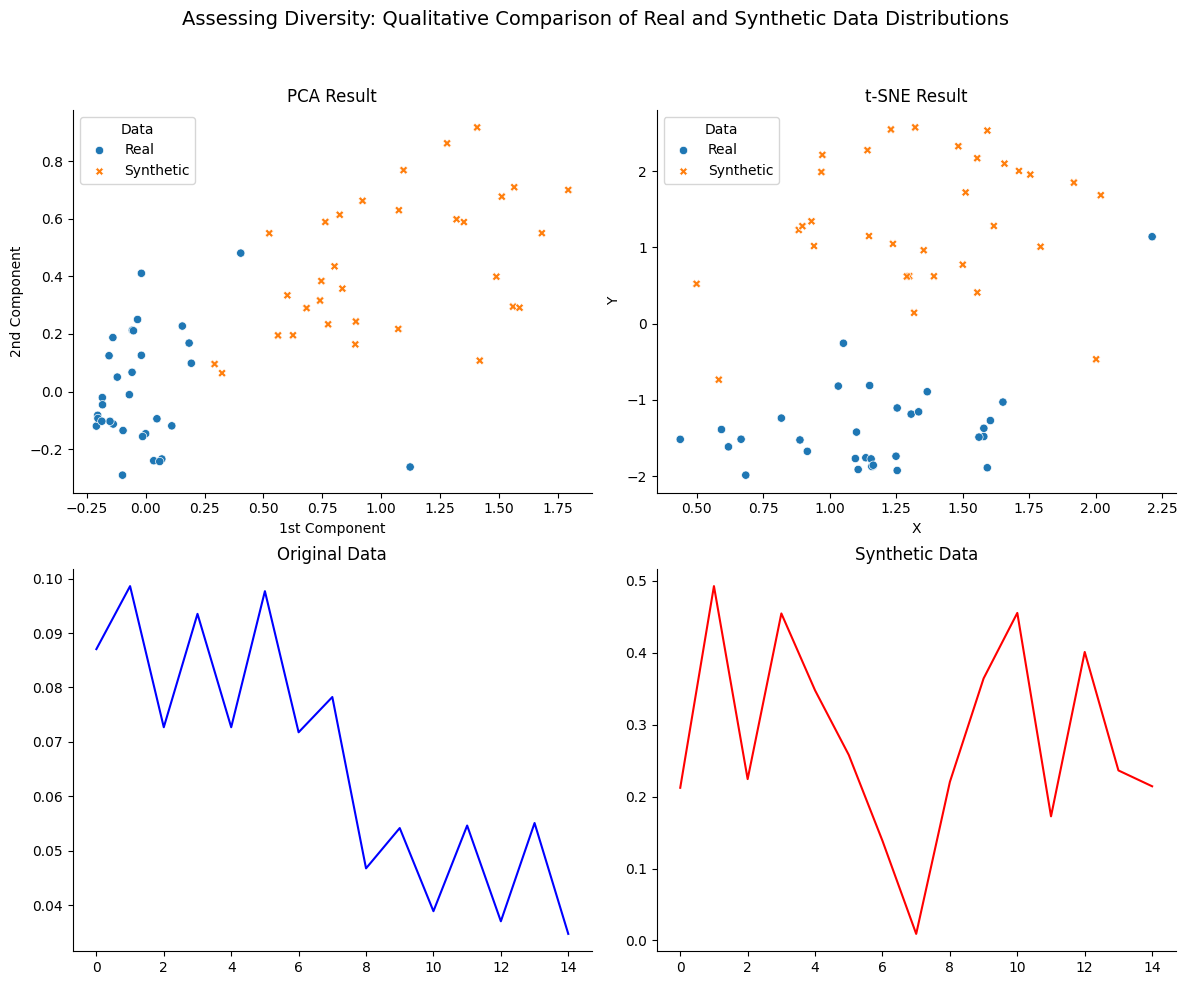

In [55]:
visualize(real_data.cpu().numpy().transpose(0,2,1), samples, seq_len)